# Human Value Detection

## Imports

In [1]:
%load_ext autoreload
%autoreload 2


from sys import platform


from drTorch.utilities import *
from drTorch.callbacks import EarlyStopper
from drTorch.metrics import F1_Score_Multi_Labels
from drTorch.wrappers import OptimizerWrapper
from drTorch.wrappers import Criterion
from drTorch.model_selection import grid_search_train_validation


from utilities import *

from models.randomUniformClassifier import RandomUniformClassifier
from models.majorityCalssifier import MajorityClassifier
from models.bertOne import BertOne
from models.berTwo import BerTwo
from models.berThree import BerThree

from sklearn.metrics import accuracy_score
from functools import partial

import numpy as np
import joblib


## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.1.1+cu121
Using device: cuda


In [3]:
if device != 'mps':
    !nvidia-smi
    

Sun Dec 17 13:18:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off | 00000000:01:00.0  On |                  N/A |
| N/A   36C    P8               3W /  80W |    161MiB /  8188MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining constants flags and work directory

In [4]:
##### PATHS AND DATAFRAME CREATION

# Directory paths for data storage
DATA_DIR = "data"
ARGUMENTS_DIR = os.path.join(DATA_DIR, "arguments")
LABELS_DIR = os.path.join(DATA_DIR, "labels")

# Directory paths for model and result storage
BERT_MODELS_DIRECTORY = "bert_models"
RESULT_DIRECTORY = 'results'  # Directory to store the results
WEIGHTS_DIRECTORY = os.path.join(RESULT_DIRECTORY, 'weights')  # Directory to store model weights

# File paths for grid search results
BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, 'bertone_grid_search_model.pkl')
BERTWO_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, 'bertwo_grid_search_model.pkl')
BERTHREE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, 'berthree_grid_search_model.pkl')

# File paths for model weights
BERTONE__WEIGHTS_PATH = os.path.join(WEIGHTS_DIRECTORY, 'bertone_wights.pth')
BERTWO_WEIGHTS_PATH = os.path.join(WEIGHTS_DIRECTORY, 'bertwo_wights.pth')
BERTHREE_WEIGHTS_PATH = os.path.join(WEIGHTS_DIRECTORY, 'berthree_wights.pth')


##### CONSTANTS 

# Number of labels and classes
N_LABELS = 4
N_CLASSES = 2

# Batch sizes for different models
BATCH_SIZE_C = 32
BATCH_SIZE_CP = 8
BATCH_SIZE_CPS = 8

# Available BERT versions
BERT_VERSIONS=["bert-base-uncased", "roberta-base"]

# BERT model constructors and tokenizer constructors
BERT_CONSTRUCTORS = {'bert-base-uncased': transformers.BertModel, 'roberta-base': transformers.RobertaModel}
BERT_TOKENIZER_CONSTRUCTORS = {'bert-base-uncased': transformers.BertTokenizer, 'roberta-base':transformers.RobertaTokenizer}

# Input and batch sizes for different model types
MODEL_INPUTS = {"C":["Conclusion"], "CP":["Conclusion", "Premise"], "CPS":["Conclusion", "Premise", "Stance"]}
MODEL_BATCH_SIZES = {"C": BATCH_SIZE_C, "CP": BATCH_SIZE_CP, "CPS": BATCH_SIZE_CPS}
MODEL_DATASET_BUILDERS = {"C":CustomDataset_C, "CP": CustomDataset_CP, "CPS": CustomDataset_CPS}


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags to control the execution of grid searches and model training
RUN_BERTONE_GRID_SEARCH = True
RUN_BERTWO_GRID_SEARCH = True
RUN_BERTHREE_GRID_SEARCH = True

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True

# Flags for fitting different BERT models
FIT_BERTONE = True
FIT_BERTWO = False
FIT_BERTHREE = False

# One-hot encoding for binary classification
CLASS_2_ONE_HOT = {class_label: np.eye(N_CLASSES)[i].astype(float).tolist() for i, class_label in enumerate(range(N_CLASSES))}


## Task 1

### Visualizing the data

In [5]:
# convert files in dataframes
train_arg_df, val_arg_df, test_arg_df = create_dfs(ARGUMENTS_DIR)
train_labels_df, val_labels_df, test_labels_df = create_dfs(LABELS_DIR)

print("Let's visualize the data: ")
display(train_arg_df.head(5))
display(train_labels_df.head(5))


Let's visualize the data: 


,Conclusion,Stance,Premise
Argument ID,,,
A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
A01008,We should ban factory farming,against,factory farming allows for the production of c...


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
Argument ID,,,,,,,,,,,,,,,,,,,,
A01002,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01005,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
A01006,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
A01007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
A01008,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


### Mapping labels to level-3 categories

In [6]:
mapping = define_mapping()
train_labels_df, val_labels_df, test_labels_df = map_to_level_3(mapping, train_labels_df, val_labels_df, test_labels_df) 

print("The training labels after the mapping are the following: ")
train_labels_df


The training labels after the mapping are the following: 


,Openess_to_change,Self_enhancement,Conservation,Self_transcendence
Argument ID,,,,
A01002,0,0,1,0
A01005,0,0,1,0
A01006,0,1,1,0
A01007,0,0,1,0
A01008,0,0,1,1
...,...,...,...,...
E08016,0,1,1,1
E08017,0,0,1,1
E08018,0,0,0,1


### Visualising the data distributions

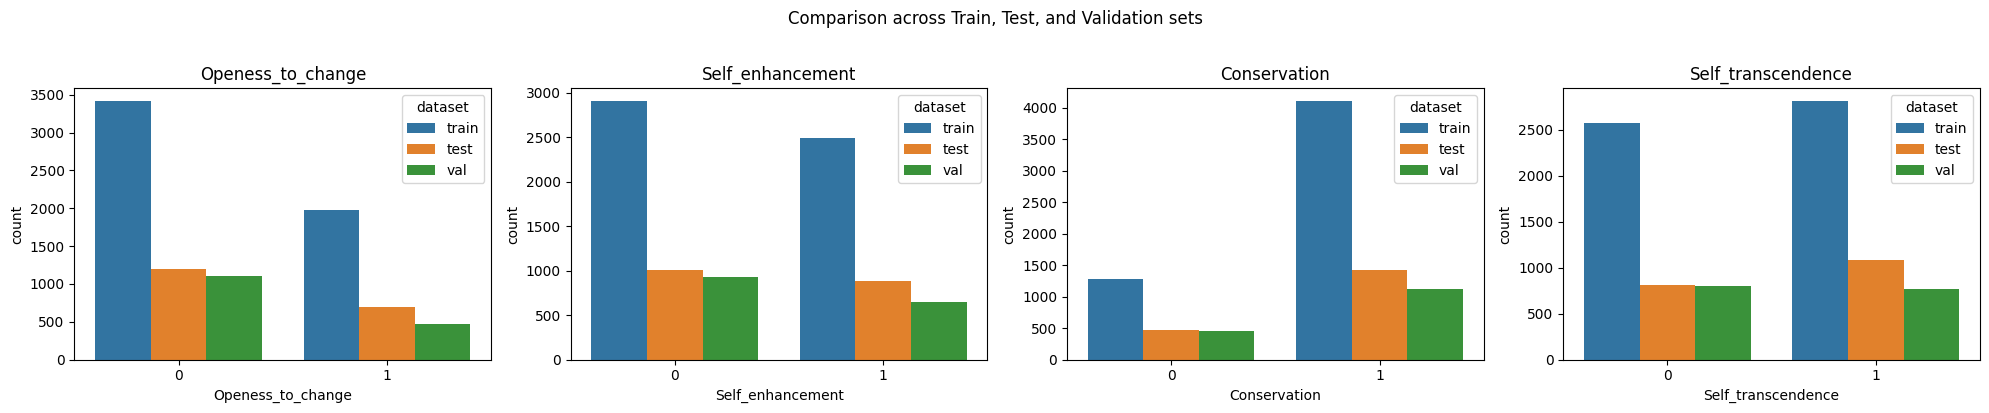

In [7]:
plot_comparison_across_sets(train_labels_df, val_labels_df, test_labels_df)


### One-hot encoding, tokenization and data loaders building

In [8]:
dataloaders = {}

if os.path.exists(BERT_MODELS_DIRECTORY):
    bert_versions_paths = [os.path.join(BERT_MODELS_DIRECTORY, version)for version in BERT_VERSIONS]
else:    
    bert_versions_paths = download_bert_models(BERT_MODELS_DIRECTORY, BERT_VERSIONS, BERT_CONSTRUCTORS, BERT_TOKENIZER_CONSTRUCTORS)  

for model_path in bert_versions_paths:
    model_name = os.path.basename(model_path)
    dataloaders[model_name]={}
    
    for model_key in MODEL_INPUTS.keys():
        dataloaders[model_name][model_key]={}
     
        dataloader_train = build_dataloader(data=train_arg_df, 
                                            labels=train_labels_df, 
                                            one_hot_mapping=CLASS_2_ONE_HOT, 
                                            pretrained_model_name_or_path=model_path, 
                                            tokenizer_constructor=BERT_TOKENIZER_CONSTRUCTORS[model_name],
                                            model_input=MODEL_INPUTS[model_key],
                                            custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                            batch_size=MODEL_BATCH_SIZES[model_key], 
                                            shuffle=True)  
    
        dataloader_val = build_dataloader(data=val_arg_df, 
                                          labels=val_labels_df, 
                                          one_hot_mapping=CLASS_2_ONE_HOT, 
                                          pretrained_model_name_or_path=model_path, 
                                          tokenizer_constructor=BERT_TOKENIZER_CONSTRUCTORS[model_name],
                                          model_input=MODEL_INPUTS[model_key],
                                          custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                          batch_size=MODEL_BATCH_SIZES[model_key], 
                                          shuffle=True)  
  
        dataloader_test = build_dataloader(data=test_arg_df, 
                                           labels=test_labels_df, 
                                           one_hot_mapping=CLASS_2_ONE_HOT, 
                                           pretrained_model_name_or_path=model_path, 
                                           tokenizer_constructor=BERT_TOKENIZER_CONSTRUCTORS[model_name],
                                           model_input=MODEL_INPUTS[model_key],
                                           custom_dataset_builder=MODEL_DATASET_BUILDERS[model_key],
                                           batch_size=MODEL_BATCH_SIZES[model_key], 
                                           shuffle=True)  
       

        dataloaders[model_name][model_key]['train'] = dataloader_train
        dataloaders[model_name][model_key]['val'] = dataloader_val
        dataloaders[model_name][model_key]['test'] = dataloader_test



"""
for batch , input in dataloaders['bert-base-uncased']['C']['train']:
    print(batch['Conclusion']['input_ids'].shape)
""";


## Task 2 

### Creating the directory to store the results for our grid search


In [9]:
if not os.path.exists(RESULT_DIRECTORY):
    os.makedirs(RESULT_DIRECTORY)
    

### Models Definition

####  1) Random uniform classifier

In [10]:
if RUN_RANDOM_CLF:
    # Create an instance of the random uniform classifier
    random_classifier = RandomUniformClassifier(N_LABELS)
    
    # Make predictions on the test set
    predicted_labels = random_classifier.predict(test_arg_df)
    
    # Accuracy of the Random Classifier
    accuracy = accuracy_score(test_labels_df, predicted_labels)
    print(f'Accuracy of the model over all the classes: {accuracy}\n')
    
    # F1 scores on the different labels singularly taken 
    f1_scorer = F1_Score_Multi_Labels(name='F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES, compute_mean=False)
    f1_scores_random_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    # AVG F1 score
    f1_avg_random_classifier = np.average(f1_scores_random_classifier)
    
    
    for idx, f1_score in enumerate(f1_scores_random_classifier):
        print(f" - {train_labels_df.columns[idx]} F1: {f1_score}")
    
    print(f'\nAverage F1: {f1_avg_random_classifier}')


Accuracy of the model over all the classes: 0.05139593908629442

 - Openess_to_change F1: 0.4669833300765103
 - Self_enhancement F1: 0.4853913989937102
 - Conservation F1: 0.4638275730953191
 - Self_transcendence F1: 0.4908207282506933

Average F1: 0.4767557576040582


####  2) Majority classifier

In [11]:
if RUN_MAJORITY_CLF:
    majority_classifier = MajorityClassifier()
    
    # Train the majority classifier (even though in practice, no training is needed)
    majority_classifier.fit(train_labels_df)
    
    # Make predictions on the test set
    predicted_labels = majority_classifier.predict(test_labels_df)
    
    # Accuracy of the Majority Classifier
    accuracy = accuracy_score(test_labels_df, predicted_labels)
    print(f'Accuracy of the model over all the classes: {accuracy}\n')
    
    # F1 scores on the different labels singularly taken 
    f1_scorer = F1_Score_Multi_Labels(name='F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES, compute_mean=False)
    f1_scores_majority_classifier = f1_scorer(torch.tensor(test_labels_df.values.tolist()), torch.tensor(predicted_labels))
    # AVG F1 score
    f1_avg_majority_classifier = np.average(f1_scores_majority_classifier)
    
    
    for idx, f1_score in enumerate(f1_scores_majority_classifier):
        print(f" - {train_labels_df.columns[idx]} F1: {f1_score}")
    
    print(f'\nAverage F1: {f1_avg_majority_classifier}')


Accuracy of the model over all the classes: 0.13642131979695432

 - Openess_to_change F1: 0.41150112023898433
 - Self_enhancement F1: 0.3708582834331337
 - Conservation F1: 0.4152133580705009
 - Self_transcendence F1: 0.32850447379633574

Average F1: 0.3815193088847386


####  3) Bert w/C

##### Searching the hyperparameters for bert w/C

In [ ]:
if RUN_BERTONE_GRID_SEARCH:
    hyperparameters_key_to_save = ['optimizer', 'pretrained_model_name_or_path', 'dropout_prob']
    seeds = [69, 4, 21]
    
    weight_classes, = calculate_class_weights(train_labels_df)
    criterion = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(weight=weight_classes, reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-5, -8, -1)]
    early_stopper = EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True)
    metrics = [[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)]] 
    

    model_hyperparameters_to_test = [{'model_class': BertOne,
                                      'dropout_prob': i,
                                      'hidden_size': 768,
                                      'pretrained_model_name_or_path': os.path.join(BERT_MODELS_DIRECTORY, version),
                                      'bert_constructor': BERT_CONSTRUCTORS[version],
                                     } for i in [0, 0.3, 0.5] for version in BERT_VERSIONS]
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': opt,
                                         'batch_size': BATCH_SIZE_C,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper,
                                         } for opt in optimizers]
    
    
    partial_build_dataloader = partial(build_dataloader, 
                                       one_hot_mapping=CLASS_2_ONE_HOT,
                                       model_input=MODEL_INPUTS['C'],
                                       custom_dataset_builder=MODEL_DATASET_BUILDERS['C'],
                                       batch_size=MODEL_BATCH_SIZES['C'])  
    

    grid_search_train_validation(train_data=(train_arg_df, train_labels_df),
                                 val_data=(val_arg_df, val_labels_df),
                                 dataloader_builder=partial_build_dataloader,
                                 dataloader_parameters_unpacking_strategy=unpacking_dataloader_builder_parameters_strategy,
                                 variable_dataloader_parameters=['pretrained_model_name_or_path', 'batch_size'],
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BERTONE_GRID_SEARCH_RESULTS_PATH) 
                                 

 61%|██████    | 11/18 [3:28:35<2:43:24, 1400.61s/it]

##### Grid search results for bert w/C

In [15]:
BertOne_grid_search_results_df = joblib.load(BERTONE_GRID_SEARCH_RESULTS_PATH)
BertOne_grid_search_results_df = BertOne_grid_search_results_df.sort_values(by='F1_macro_avg_val_mean', ascending=False)

BertOne_grid_search_results_df


,hidden_size,optimizer,pretrained_model_name_or_path,mean_time,std_time,F1_macro_avg_train_mean,F1_macro_avg_train_std,F1_macro_avg_val_mean,F1_macro_avg_val_std
5,768,Adam lr=1e-05,bert_models/roberta-base,247.753,100.259,0.695055,0.009359,0.665047,0.002546
3,768,Adam lr=1e-05,bert_models/roberta-base,251.110,40.864,0.700074,0.004538,0.659232,0.002329
1,768,Adam lr=1e-05,bert_models/roberta-base,223.467,68.336,0.694482,0.007262,0.658473,0.003444
9,768,Adam lr=1e-06,bert_models/roberta-base,526.212,178.081,0.693204,0.008179,0.657026,0.004140
7,768,Adam lr=1e-06,bert_models/roberta-base,334.214,55.516,0.685973,0.008183,0.656944,0.004170
11,768,Adam lr=1e-06,bert_models/roberta-base,429.952,131.651,0.682633,0.011238,0.655464,0.003932
2,768,Adam lr=1e-05,bert_models/bert-base-uncased,312.710,55.525,0.702546,0.004213,0.649182,0.002071
4,768,Adam lr=1e-05,bert_models/bert-base-uncased,303.515,81.305,0.698685,0.010572,0.645494,0.001993
0,768,Adam lr=1e-05,bert_models/bert-base-uncased,234.973,54.231,0.694593,0.009100,0.645207,0.006020
6,768,Adam lr=1e-06,bert_models/bert-base-uncased,376.276,67.052,0.676477,0.009050,0.631963,0.021034


#### 4) Bert w/CP

##### Searching the hyperparameters for bert w/CP


In [ ]:
if RUN_BERTWO_GRID_SEARCH:
    hyperparameters_key_to_save = ['optimizer', 'pretrained_model_name_or_path', 'dropout_prob']
    seeds = [69, 4, 21]
    
    weight_classes = calculate_class_weights(train_labels_df)
    criterion = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(weight=weight_classes, reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-5, -8, -1)]
    early_stopper = EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True)
    metrics = [[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)]] 
    

    model_hyperparameters_to_test = [{'model_class': BerTwo,
                                      'dropout_prob': i,
                                      'hidden_size': 768,
                                      'pretrained_model_name_or_path': os.path.join(BERT_MODELS_DIRECTORY, version),
                                      'bert_constructor': BERT_CONSTRUCTORS[version],
                                     } for i in [0, 0.3, 0.5] for version in BERT_VERSIONS]
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': opt,
                                         'batch_size': BATCH_SIZE_CP,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper,
                                         } for opt in optimizers]
    
    
    partial_build_dataloader = partial(build_dataloader, 
                                       one_hot_mapping=CLASS_2_ONE_HOT,
                                       model_input=MODEL_INPUTS['CP'],
                                       custom_dataset_builder=MODEL_DATASET_BUILDERS['CP'],
                                       batch_size=MODEL_BATCH_SIZES['CP'])  
   

    grid_search_train_validation(train_data=(train_arg_df, train_labels_df),
                                 val_data=(val_arg_df, val_labels_df),
                                 dataloader_builder=partial_build_dataloader,
                                 dataloader_parameters_unpacking_strategy=unpacking_dataloader_builder_parameters_strategy,
                                 variable_dataloader_parameters=['pretrained_model_name_or_path', 'batch_size'],
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BERTWO_GRID_SEARCH_RESULTS_PATH) 
                                 

##### Grid search results for bert w/CP


In [ ]:
BerTwo_grid_search_results_df = joblib.load(BERTWO_GRID_SEARCH_RESULTS_PATH)
BerTwo_grid_search_results_df = BerTwo_grid_search_results_df.sort_values(by='F1_macro_val_mean', ascending=False)
BerTwo_grid_search_results_df


#### 5) Bert w/CPS

##### Searching the hyperparameters for bert w/C


In [ ]:
if RUN_BERTWO_GRID_SEARCH:
    hyperparameters_key_to_save = ['optimizer', 'pretrained_model_name_or_path', 'dropout_prob']
    seeds = [69, 4, 21]
    
    weight_classes = calculate_class_weights(train_labels_df)
    criterion = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(weight=weight_classes, reduction='none'), reduction_function=torch.mean)
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={10**i}', optimizer_partial_params={'lr':10 ** i}) for i in range(-5, -8, -1)]
    early_stopper = EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True)
    metrics = [[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)]] 
    

    model_hyperparameters_to_test = [{'model_class': BerThree,
                                      'dropout_prob': i,
                                      'hidden_size': 768,
                                      'pretrained_model_name_or_path': os.path.join(BERT_MODELS_DIRECTORY, version),
                                      'bert_constructor': BERT_CONSTRUCTORS[version],
                                     } for i in [0, 0.3, 0.5] for version in BERT_VERSIONS]
    
    training_hyperparameters_to_test = [{'num_epochs': 200,
                                         'optimizer': opt,
                                         'batch_size': BATCH_SIZE_CPS,
                                         'criterion': criterion,
                                         'metrics': metrics[0],
                                         'early_stopper': early_stopper,
                                         } for opt in optimizers]
    
    
    partial_build_dataloader = partial(build_dataloader, 
                                       one_hot_mapping=CLASS_2_ONE_HOT,
                                       model_input=MODEL_INPUTS['CPS'],
                                       custom_dataset_builder=MODEL_DATASET_BUILDERS['CPS'],
                                       batch_size=MODEL_BATCH_SIZES['CPS'])  
    

    grid_search_train_validation(train_data=(train_arg_df, train_labels_df),
                                 val_data=(val_arg_df, val_labels_df),
                                 dataloader_builder=partial_build_dataloader,
                                 dataloader_parameters_unpacking_strategy=unpacking_dataloader_builder_parameters_strategy(),
                                 variable_dataloader_parameters=['pretrained_model_name_or_path', 'batch_size'],
                                 shuffle=True,
                                 model_hyperparameters_to_test=model_hyperparameters_to_test,
                                 training_hyperparameters_to_test=training_hyperparameters_to_test,
                                 hyperparameters_key_to_save=hyperparameters_key_to_save,
                                 seeds=seeds,
                                 device=device,
                                 path_to_grid_search_results=BERTHREE_GRID_SEARCH_RESULTS_PATH) 
                                 

##### Grid search results for bert w/C


In [ ]:
BerThree_grid_search_results_df = joblib.load(BERTHREE_GRID_SEARCH_RESULTS_PATH)
BerThree_grid_search_results_df = BerThree_grid_search_results_df.sort_values(by='F1_macro_val_mean', ascending=False)
BerThree_grid_search_results_df


##### Extracting the best hyperparameters for our models

In [ ]:
best_hyperparameters_bertOne = BertOne_grid_search_results_df.iloc[0].copy()
best_hyperparameters_berTwo = BerTwo_grid_search_results_df.iloc[0].copy()
best_hyperparameters_berThree = BerThree_grid_search_results_df.iloc[0].copy()

best_hyperparameters_bertOne['source'] = 'bertOne'
best_hyperparameters_berTwo['source'] = 'berTwo'
best_hyperparameters_berTwo['source'] = 'berThree'

best_hyperparameters_df = pd.concat([best_hyperparameters_bertOne, best_hyperparameters_berTwo, best_hyperparameters_berThree], 
                                    ignore_index=True, 
                                    axis=1).T
best_hyperparameters_df.set_index('source', inplace=True)

best_hyperparameters_df



In [ ]:
#------------------------------------------------------------

In [ ]:
if FIT_BERTONE:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-5}', optimizer_partial_params={'lr': 1e-5})       
    
    weights_tensor = calculate_class_weights(train_labels_df)
    criterion_test = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(weight=weights_tensor, reduction='none'), reduction_function=torch.mean)
    
    bert1 = BertOne(dropout_prob=0.3, hidden_size= 768, pretrained_model_name_or_path='roberta-base', bert_constructor=transformers.RobertaModel).to(device)
    
    bert1_history = bert1.fit(train_loader=dataloaders['roberta-base']['C']['train'], 
                              val_loader=dataloaders['roberta-base']['C']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)], 
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True),
                              num_epochs=200)



In [11]:
if FIT_BERTWO:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-5}', optimizer_partial_params={'lr': 1e-5})          
   
    weights_tensor = calculate_class_weights(train_labels_df)
    criterion_test = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(weight=weights_tensor, reduction='none'), reduction_function=torch.mean)
    
    bert2 = BerTwo(dropout_prob=0.3, hidden_size= 768, pretrained_model_name_or_path='roberta-base', bert_constructor=transformers.RobertaModel).to(device)
    
    bert2_history = bert2.fit(train_loader=dataloaders['roberta-base']['CP']['train'], 
                              val_loader=dataloaders['roberta-base']['CP']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)], 
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True),
                              num_epochs=200)
    

In [12]:
if FIT_BERTHREE:
    optimizer_test = OptimizerWrapper(torch.optim.Adam, identifier=f'lr={1e-5}', optimizer_partial_params={'lr': 1e-5})          
    
    weights_tensor = calculate_class_weights(train_labels_df)
    criterion_test = Criterion('loss', loss_function=torch.nn.BCEWithLogitsLoss(weight=weights_tensor, reduction='none'), reduction_function=torch.mean)
    
    bert3 = BerThree(dropout_prob=0.3, hidden_size= 768, pretrained_model_name_or_path='roberta-base', bert_constructor=transformers.RobertaModel).to(device)
    
    bert3_history = bert3.fit(train_loader=dataloaders['roberta-base']['CPS']['train'], 
                              val_loader=dataloaders['roberta-base']['CPS']['val'], 
                              criterion=criterion_test, 
                              metrics=[F1_Score_Multi_Labels('F1_macro_avg', num_labels=N_LABELS, num_classes=N_CLASSES)], 
                              optimizer=optimizer_test,
                              early_stopper=EarlyStopper(monitor='F1_macro_avg', patience=4, delta=0, mode='max', restore_weights=True),
                              num_epochs=200)
    

 Epoch: 1/10 Iterations: 675/675 Time: 228.165s - loss: 0.631562829017639 - F1_macro_avg: 0.640598583937364 - val_loss: 0.65085756778717 - val_F1_macro_avg: 0.616415056308666 
 Epoch: 2/10 Iterations: 675/675 Time: 228.55s - loss: 0.611115515232086 - F1_macro_avg: 0.669361836044251 - val_loss: 0.644732236862183 - val_F1_macro_avg: 0.634359010870163 
 Epoch: 3/10 Iterations: 675/675 Time: 228.407s - loss: 0.596520721912384 - F1_macro_avg: 0.679985521111272 - val_loss: 0.636972665786743 - val_F1_macro_avg: 0.6456911217218 
 Epoch: 4/10 Iterations: 675/675 Time: 228.656s - loss: 0.579547941684723 - F1_macro_avg: 0.696843100072342 - val_loss: 0.627235233783722 - val_F1_macro_avg: 0.661217992450717 
 Epoch: 5/10 Iterations: 675/675 Time: 228.371s - loss: 0.564381182193756 - F1_macro_avg: 0.714298124304912 - val_loss: 0.617979526519775 - val_F1_macro_avg: 0.668093739867831 
 Epoch: 6/10 Iterations: 675/675 Time: 228.747s - loss: 0.551492869853973 - F1_macro_avg: 0.726471985758013 - val_loss: